# 1. CSV

In [4]:
import os
import json
import pandas as pd

# Where the model_features folder is
base_dir = "../model_features"

# Store all summary records
summary = []
time_expanded = []

# Loop through split types
for split in ["randomsplit", "temporal"]:
    split_path = os.path.join(base_dir, split)
    for model_folder in os.listdir(split_path):
        if not model_folder.endswith("_ablation"):
            continue

        model_type = model_folder.replace("_ablation", "").upper()
        model_path = os.path.join(split_path, model_folder)

        # Loop through ablation folders
        for ablation in os.listdir(model_path):
            ablation_path = os.path.join(model_path, ablation)

            # Skip if it's not a directory
            if not os.path.isdir(ablation_path):
                continue

            # Construct the key name
            model_split = f"{model_type}-{split.capitalize()}"

            # Try load the 4 expected files
            try:
                with open(os.path.join(ablation_path, "fp_counts.json")) as f:
                    fp_count = json.load(f)
                with open(os.path.join(ablation_path, "fn_counts.json")) as f:
                    fn_count = json.load(f)
                with open(os.path.join(ablation_path, "fp_time.json")) as f:
                    fp_time = json.load(f)
                with open(os.path.join(ablation_path, "fn_time.json")) as f:
                    fn_time = json.load(f)
            except FileNotFoundError:
                print(f"Missing files in: {ablation_path}")
                continue

            # Summary row
            summary.append({
                "Model-Split": model_split,
                "Ablation": ablation,
                "FP Count": fp_count,
                "FN Count": fn_count
            })

            # Time-expanded rows
            for t in fp_time:
                time_expanded.append({
                    "Model-Split": model_split,
                    "Ablation": ablation,
                    "Type": "FP",
                    "Time": int(t),
                    "Count": 1
                })
            for t in fn_time:
                time_expanded.append({
                    "Model-Split": model_split,
                    "Ablation": ablation,
                    "Type": "FN",
                    "Time": int(t),
                    "Count": 1
                })

# Convert and save
df_summary = pd.DataFrame(summary)
df_summary.to_csv("../results/analysis/fp_fn_summary_featured.csv", index=False)

df_time = pd.DataFrame(time_expanded)
df_time = df_time.groupby(["Model-Split", "Ablation", "Type", "Time"]).sum().reset_index()
df_time.to_csv("../results/analysis/fp_fn_by_time_featured.csv", index=False)


In [ ]:
# Add paths for base models (non-ablation)
base_model_folders = {
    "Randomsplit": "../model_randomsplit",
    "Temporal": "../model_temporal"
}

for split_type, split_path in base_model_folders.items():
    for model_name in ["GAT", "GCN", "SAGE"]:
        model_path = os.path.join(split_path, model_name)

        try:
            with open(os.path.join(model_path, "fp_counts.json")) as f:
                fp_count = json.load(f)
            with open(os.path.join(model_path, "fn_counts.json")) as f:
                fn_count = json.load(f)
            with open(os.path.join(model_path, "fp_time.json")) as f:
                fp_time = json.load(f)
            with open(os.path.join(model_path, "fn_time.json")) as f:
                fn_time = json.load(f)
        except FileNotFoundError:
            print(f"Missing files in: {model_path}")
            continue

        model_split = f"{model_name}-{split_type}"
        ablation = "no_features"  # for non-ablation models

        summary.append({
            "Model-Split": model_split,
            "Ablation": ablation,
            "FP Count": fp_count,
            "FN Count": fn_count
        })

        for t in fp_time:
            time_expanded.append({
                "Model-Split": model_split,
                "Ablation": ablation,
                "Type": "FP",
                "Time": int(t),
                "Count": 1
            })
        for t in fn_time:
            time_expanded.append({
                "Model-Split": model_split,
                "Ablation": ablation,
                "Type": "FN",
                "Time": int(t),
                "Count": 1
            })

# Re-save both CSVs (now with base models included)
df_summary = pd.DataFrame(summary)
df_summary.to_csv("../results/analysis/fp_fn_summary_all.csv", index=False)

df_time = pd.DataFrame(time_expanded)
df_time = df_time.groupby(["Model-Split", "Ablation", "Type", "Time"]).sum().reset_index()
df_time.to_csv("../results/analysis/fp_fn_by_time_all.csv", index=False)


In [1]:
import os
import json
import pandas as pd

# Configuration
splits = {
    "Random": "../model_features/randomsplit",
    "Temporal": "../model_features/temporal"
}
output_dir = "../results"
os.makedirs(output_dir, exist_ok=True)

# Expected seed order (known from project)
seed_list = [42, 123, 777, 2023, 31415]

# Helper function to process one ablation group
def process_model_split(model_type, split_type, model_path):
    all_rows = []

    for ablation_name in os.listdir(model_path):
        ablation_path = os.path.join(model_path, ablation_name)
        if not os.path.isdir(ablation_path):
            continue

        seed_json_path = os.path.join(ablation_path, "seed_metrics.json")
        if not os.path.exists(seed_json_path):
            print(f"[!] Skipping (missing): {seed_json_path}")
            continue

        with open(seed_json_path, "r") as f:
            metrics = json.load(f)

        if not isinstance(metrics, list):
            print(f"[!] Malformed: {seed_json_path}")
            continue

        for i, record in enumerate(metrics):
            record["ablation_type"] = ablation_name
            record["seed"] = seed_list[i] if i < len(seed_list) else f"unknown_{i}"
            all_rows.append(record)

    if not all_rows:
        print(f"[!] No data for {model_type}-{split_type}")
        return

    df = pd.DataFrame(all_rows)

    # Ensure ablation_type and seed are first columns
    columns = ['ablation_type', 'seed'] + [col for col in df.columns if col not in ['ablation_type', 'seed']]
    df = df[columns]

    out_path = os.path.join(output_dir, f"{model_type}-{split_type}_metrics_feature.csv")
    df.to_csv(out_path, index=False)
    print(f"✅ Saved: {out_path}")

# Main loop
for split_type, base_path in splits.items():
    for model_folder in os.listdir(base_path):
        if not model_folder.endswith("_ablation"):
            continue
        model_type = model_folder.replace("_ablation", "").upper()  # GAT_ablation → GAT
        model_path = os.path.join(base_path, model_folder)
        process_model_split(model_type, split_type, model_path)


✅ Saved: ../results\GAT-Random_metrics_feature.csv
✅ Saved: ../results\GCN-Random_metrics_feature.csv
✅ Saved: ../results\SAGE-Random_metrics_feature.csv
✅ Saved: ../results\GAT-Temporal_metrics_feature.csv
✅ Saved: ../results\GCN-Temporal_metrics_feature.csv
✅ Saved: ../results\SAGE-Temporal_metrics_feature.csv


In [22]:
import os
import pandas as pd

# Paths to your feature files
feature_files = {
    "GAT-Random": "GAT-Random_metrics_feature.csv",
    "GAT-Temporal": "GAT-Temporal_metrics_feature.csv",
    "GCN-Random": "GCN-Random_metrics_feature.csv",
    "GCN-Temporal": "GCN-Temporal_metrics_feature.csv",
    "SAGE-Random": "SAGE-Random_metrics_feature.csv",
    "SAGE-Temporal": "SAGE-Temporal_metrics_feature.csv"
}

# Store output rows
ablation_rows = []

for model_split, file in feature_files.items():
    path = f"../results/{file}"  # Adjust if file is elsewhere
    df = pd.read_csv(path)

    if "ablation_type" not in df.columns:
        continue

    for ablation, group in df.groupby("ablation_type"):
        row = {
            "Model-Split": model_split,
            "Ablation": ablation
        }

        for col in group.columns:
            if col in ["seed", "ablation_type"]:
                continue
            row[f"{col}_mean"] = group[col].mean()
            row[f"{col}_std"] = group[col].std()

        ablation_rows.append(row)

# Create and save final DataFrame
df_ablation_summary = pd.DataFrame(ablation_rows)
df_ablation_summary.to_csv("../results/analysis/ablation_summary_metrics_all.csv", index=False)


In [24]:
import pandas as pd

# Load full ablation summary with extra metrics
df_ablation = pd.read_csv("../results/analysis/ablation_summary_metrics_all.csv")

# Define raw (non-feature) baseline files
baseline_files = {
    "GAT-Random": "GAT-Random_metrics.csv",
    "GAT-Temporal": "GAT-Temporal_metrics.csv",
    "GCN-Random": "GCN-Random_metrics.csv",
    "GCN-Temporal": "GCN-Temporal_metrics.csv",
    "SAGE-Random": "SAGE-Random_metrics.csv",
    "SAGE-Temporal": "SAGE-Temporal_metrics.csv"
}

# Extract averages from raw model files
raw_metrics = ["accuracy", "f1_macro", "mcc", "specificity", "fpr", "fnr"]
baseline_records = []

for model_split, path in baseline_files.items():
    df_raw = pd.read_csv(f"../results/{path}")
    record = {"Model-Split": model_split}
    for metric in raw_metrics:
        record[f"{metric}_raw"] = df_raw[metric].mean()
    baseline_records.append(record)

df_baseline = pd.DataFrame(baseline_records)

# Merge and compute deltas
df = pd.merge(df_ablation, df_baseline, on="Model-Split", how="left")

# Compute per-metric deltas
for metric in raw_metrics:
    mean_col = f"{metric}_mean"
    raw_col = f"{metric}_raw"
    delta_col = f"{metric}_delta"
    if mean_col in df.columns:
        df[delta_col] = df[mean_col] - df[raw_col]

# Save result
df.to_csv("../results/analysis/ablation_vs_baseline_deltas_extended.csv", index=False)
print("✅ Saved: ablation_vs_baseline_deltas_extended.csv")


✅ Saved: ablation_vs_baseline_deltas_extended.csv


## 1.1 Sanity check to validate csv values with json files.

In [3]:
import os
import json
import pandas as pd

# Configuration for both models
csv_sources = {
    "../model_features/randomsplit": ("Random", True),
    "../model_features/temporal": ("Temporal", True),
    "../model_randomsplit": ("Random", False),
    "../model_temporal": ("Temporal", False),
}
results_dir = "../results"
seed_list = [42, 123, 777, 2023, 31415]

# Function to load seed_metrics
def load_seed_metrics_json(json_path):
    with open(json_path, "r") as f:
        return json.load(f)

# Main loop
for base_folder, (split_type, is_featured) in csv_sources.items():
    for model_name in os.listdir(base_folder):
        if is_featured and not model_name.endswith("_ablation"):
            continue
        if not is_featured and model_name not in {"GAT", "GCN", "SAGE"}:
            continue

        ablation_root = os.path.join(base_folder, model_name)
        model_tag = model_name.replace("_ablation", "").upper() if is_featured else model_name

        # Construct CSV path
        csv_name = f"{model_tag}-{split_type}_metrics_feature.csv" if is_featured else f"{model_tag}-{split_type}_metrics.csv"
        csv_path = os.path.join(results_dir, csv_name)

        if not os.path.exists(csv_path):
            print(f"[!] CSV missing: {csv_path}")
            continue

        df_csv = pd.read_csv(csv_path)

        if is_featured:
            # Loop through each ablation group
            for ablation in df_csv['ablation_type'].unique():
                ablation_path = os.path.join(ablation_root, ablation, "seed_metrics.json")
                if not os.path.exists(ablation_path):
                    print(f"[!] Missing JSON: {ablation_path}")
                    continue

                metrics = load_seed_metrics_json(ablation_path)
                df_slice = df_csv[df_csv['ablation_type'] == ablation].sort_values("seed").reset_index(drop=True)

                for i, row in enumerate(metrics):
                    for key in row:
                        csv_val = df_slice.iloc[i][key]
                        if pd.isna(csv_val) and row[key] is None:
                            continue
                        if abs(csv_val - row[key]) > 1e-6:
                            print(f"[Mismatch] {csv_name} :: ablation={ablation} :: seed={df_slice.iloc[i]['seed']} :: {key} :: CSV={csv_val} vs JSON={row[key]}")
        else:
            json_path = os.path.join(ablation_root, "seed_metrics.json")
            if not os.path.exists(json_path):
                print(f"[!] Missing JSON: {json_path}")
                continue

            metrics = load_seed_metrics_json(json_path)
            df_csv_sorted = df_csv.sort_values("seed").reset_index(drop=True)

            for i, row in enumerate(metrics):
                for key in row:
                    csv_val = df_csv_sorted.iloc[i][key]
                    if pd.isna(csv_val) and row[key] is None:
                        continue
                    if abs(csv_val - row[key]) > 1e-6:
                        print(f"[Mismatch] {csv_name} :: seed={df_csv_sorted.iloc[i]['seed']} :: {key} :: CSV={csv_val} vs JSON={row[key]}")

print("Verification complete.")


Verification complete.


## 2. Per-Ablation Analysis of Feature-Engineered GNNs

This section investigates how different ablation types affect model performance across GAT, GCN, and GraphSAGE architectures under both random and temporal training splits.

We analyze key evaluation metrics (`accuracy`, `f1_macro`, `f1_illicit`, `mcc`, and `bal_acc`) grouped by ablation type. Each ablation group represents a subset of the full feature set, enabling us to assess the contribution of specific behavioral or structural features in anti-money laundering detection performance.

Our goal is to:
- Identify which ablation types consistently improve model performance.
- Detect any models that are sensitive to particular features.
- Highlight ablations that underperform or introduce variance.


### 2.1 Ablation Comparison for GAT-Random

This plot shows the performance of different ablation groups on the GAT model trained with a random split. Each bar represents the mean value over 5 seeds, and the error bars show the standard deviation.

The `base+structural` ablation appears to outperform other ablations across accuracy, F1, and MCC, while the `all` feature set slightly underperforms, suggesting potential feature redundancy.


In [59]:
import pandas as pd
from IPython.display import display

# Load full comparison table
df = pd.read_csv("../results/analysis/ablation_vs_baseline_deltas_extended.csv")

# Map to A1–A7 shorthand (optional, now unused)
abbrev_map = {
    "base": "A1",
    "base+structural": "A2",
    "base+basic_temporal": "A3",
    "base+basic_temporal+typology": "A4",
    "base+typology": "A5",
    "all": "A6",
    "base+structural+typology": "A7"
}
df["Ablation Code"] = df["Ablation"].map(abbrev_map).fillna(df["Ablation"])

# Filter: Best F1 macro per model-split
best_rows = df.loc[df.groupby("Model-Split")["f1_macro_mean"].idxmax()]

# Compute % gain columns
best_rows["F1 Macro % Gain"] = 100 * best_rows["f1_macro_delta"] / (best_rows["f1_macro_mean"] - best_rows["f1_macro_delta"])
best_rows["MCC % Gain"] = 100 * best_rows["mcc_delta"] / (best_rows["mcc_mean"] - best_rows["mcc_delta"])
best_rows["Accuracy % Gain"] = 100 * best_rows["accuracy_delta"] / (best_rows["accuracy_mean"] - best_rows["accuracy_delta"])
best_rows["FPR % Gain"] = 100 * best_rows["fpr_delta"] / (best_rows["fpr_delta"] + best_rows["fpr_mean"])
best_rows["FNR % Gain"] = 100 * best_rows["fnr_delta"] / (best_rows["fnr_delta"] + best_rows["fnr_mean"])

# Select only Model-Split and % gain columns
cols = [
    "Model-Split",
    "F1 Macro % Gain", "MCC % Gain", "Accuracy % Gain",
    "FPR % Gain", "FNR % Gain"
]
df_percent = best_rows[cols].copy().round(2)

# Display result
display(df_percent)




,Model-Split,F1 Macro % Gain,MCC % Gain,Accuracy % Gain,FPR % Gain,FNR % Gain
4,GAT-Random,5.59,11.79,1.22,-99.89,10.29
11,GAT-Temporal,6.97,21.70,1.81,-9.24,-709.43
16,GCN-Random,2.68,5.82,0.59,-21.93,1.90
24,GCN-Temporal,1.54,3.24,0.03,-4.83,11.80
30,SAGE-Random,0.54,1.04,0.14,-13.50,9.82
37,SAGE-Temporal,0.19,0.47,0.03,-0.85,-0.65


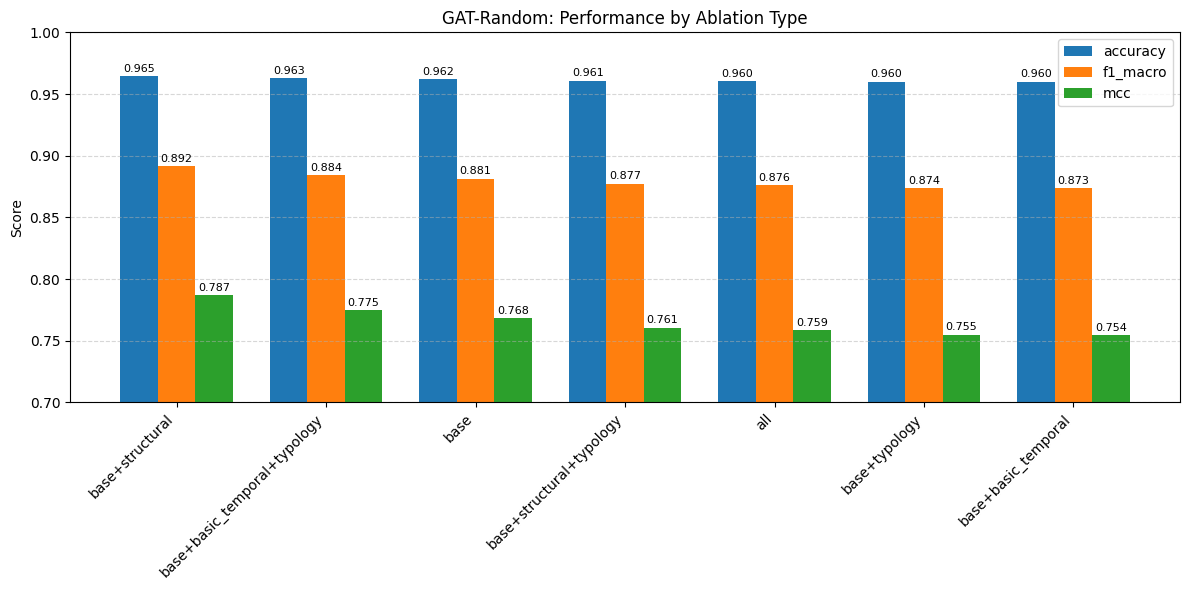

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your saved summary
df = pd.read_csv("../results/analysis/ablation_summary_metrics.csv")
df_gat_random = df[df["Model-Split"] == "GAT-Random"].copy()

# Sort by f1_macro_mean
df_gat_random = df_gat_random.sort_values("f1_macro_mean", ascending=False)

# Setup
plt.figure(figsize=(12, 6))
x = range(len(df_gat_random))
width = 0.25
metrics = ["accuracy_mean", "f1_macro_mean", "mcc_mean"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot each metric
for i, metric in enumerate(metrics):
    plt.bar([p + i * width for p in x],
            df_gat_random[metric],
            width,
            label=metric.replace("_mean", ""),
            color=colors[i])

# Formatting
plt.xticks([p + width for p in x], df_gat_random["Ablation"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("GAT-Random: Performance by Ablation Type")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

# Add value labels
for i, metric in enumerate(metrics):
    for j, val in enumerate(df_gat_random[metric]):
        plt.text(j + i * width, val + 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### 2.2 Ablation Comparison for GAT-Temporal

This plot shows the performance of different ablation groups on the GAT model trained with a temporal split. Each bar represents the mean value over 5 seeds, and the metric values are labeled above each bar.

#### Key Findings:
- The `base+structural` ablation again provides the strongest performance across F1-macro (**0.787**) and MCC (**0.578**), confirming the critical role of structural graph information even in temporally evolving transaction networks.
- The full feature set (`all`) continues to underperform more focused combinations, reinforcing the idea that including all features introduces redundancy or noise.
- The `base+basic_temporal` ablation performs the worst, especially in MCC (**0.407**), indicating that simple time-based indicators are insufficient for capturing illicit behavior in temporal training.
- Ablations that include **typology** (e.g., `base+typology`) slightly boost F1 over `base` but still fall short of structural-enhanced configurations.

This indicates that GAT leverages **structural proximity and neighborhood signal** more effectively than behavioral or temporal-only information when applied to time-sensitive Bitcoin AML graphs.


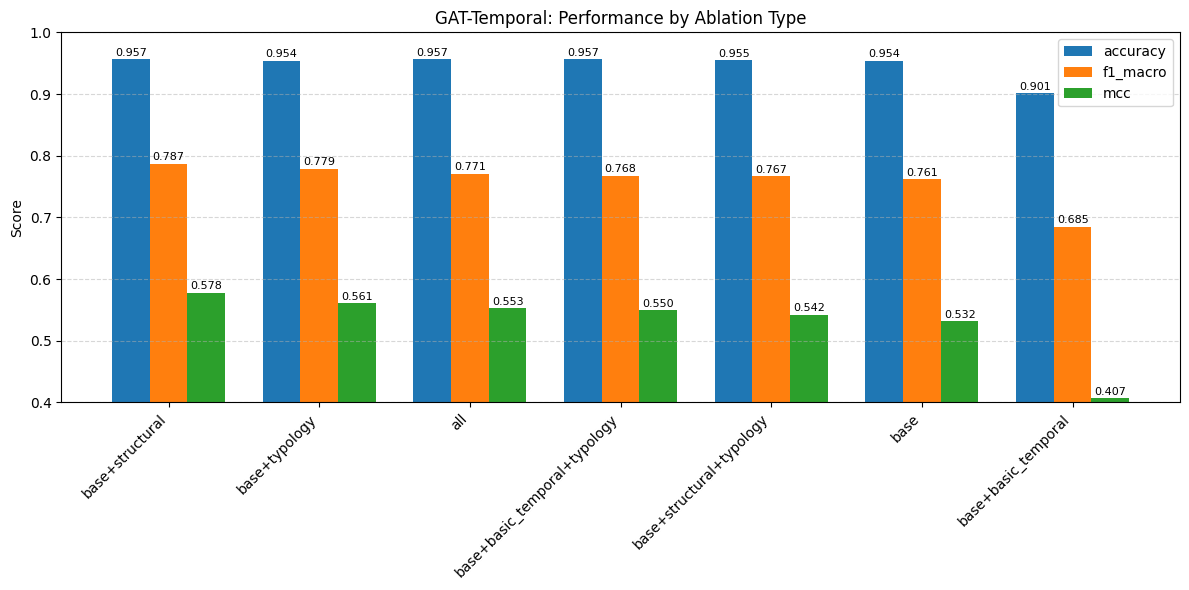

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load summary data
df = pd.read_csv("../results/analysis/ablation_summary_metrics.csv")
df_gat_temporal = df[df["Model-Split"] == "GAT-Temporal"].copy()
df_gat_temporal = df_gat_temporal.sort_values("f1_macro_mean", ascending=False)

# Plot setup
plt.figure(figsize=(12, 6))
x = range(len(df_gat_temporal))
width = 0.25
metrics = ["accuracy_mean", "f1_macro_mean", "mcc_mean"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Bar chart
for i, metric in enumerate(metrics):
    plt.bar([p + i * width for p in x],
            df_gat_temporal[metric],
            width,
            label=metric.replace("_mean", ""),
            color=colors[i])

plt.xticks([p + width for p in x], df_gat_temporal["Ablation"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("GAT-Temporal: Performance by Ablation Type")
plt.ylim(0.4, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

# Add value labels
for i, metric in enumerate(metrics):
    for j, val in enumerate(df_gat_temporal[metric]):
        plt.text(j + i * width, val + 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### 2.3 Ablation Comparison for GCN-Random

This plot shows the effect of feature ablations on GCN performance under random split training. Each bar reflects the average across 5 seeds.

#### Key Findings:
- The strongest performance was achieved by `base+basic_temporal` and `base+basic_temporal+typology` ablations, both showing high F1-macro (~0.863) and MCC (~0.733–0.734).
- Unlike GAT, temporal features play a central role in GCN’s performance. In fact, `base+basic_temporal` outperformed the `all` feature set across all core metrics.
- The full feature set (`all`) ranked mid-tier, reinforcing the notion that GCN suffers from feature over-saturation when using all engineered attributes.
- `base+structural` and `base+typology` trails behind temporal-heavy ablations, suggesting that in GCN’s message-passing scheme, static structural features are less impactful than temporal evolution cues.

This suggests GCN's aggregation favors **temporally dynamic patterns** over static graph properties, in contrast to what we observed with GAT.


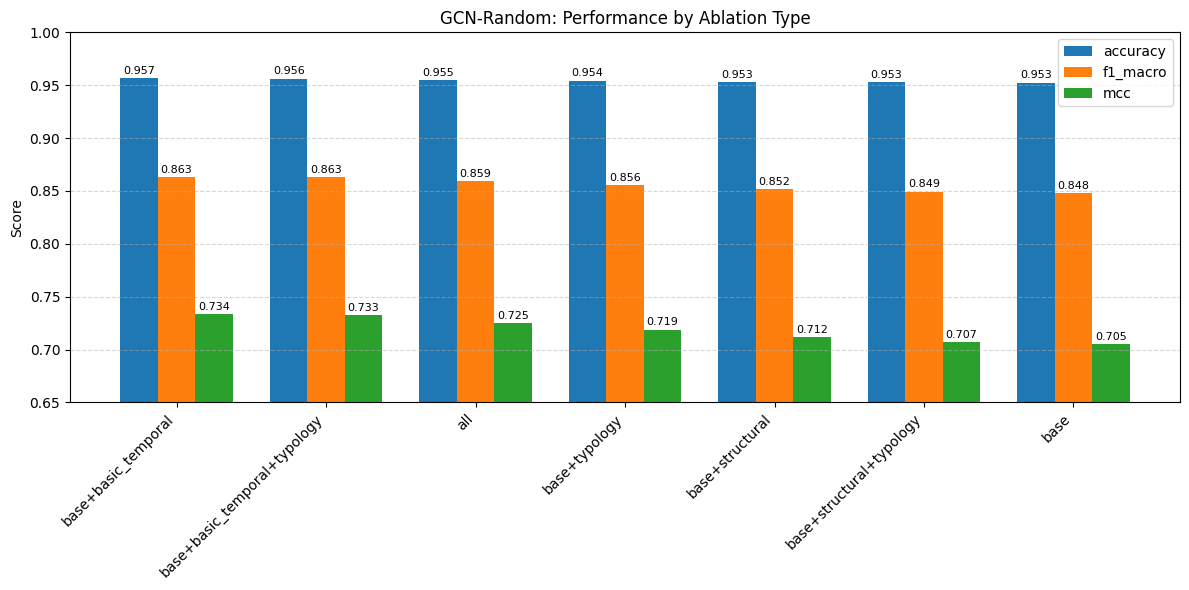

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and aggregate GCN-Random ablation performance
df = pd.read_csv("../results/GCN-Random_metrics_feature.csv")
df = df[df["ablation_type"].notna()]
summary = df.groupby("ablation_type").agg({
    "accuracy": ["mean", "std"],
    "f1_macro": ["mean", "std"],
    "mcc": ["mean", "std"]
}).reset_index()
summary.columns = ["Ablation", "accuracy_mean", "accuracy_std", "f1_macro_mean", "f1_macro_std", "mcc_mean", "mcc_std"]
summary = summary.sort_values("f1_macro_mean", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
x = range(len(summary))
width = 0.25
metrics = ["accuracy_mean", "f1_macro_mean", "mcc_mean"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, metric in enumerate(metrics):
    plt.bar([p + i * width for p in x],
            summary[metric],
            width,
            label=metric.replace("_mean", ""),
            color=colors[i])

plt.xticks([p + width for p in x], summary["Ablation"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("GCN-Random: Performance by Ablation Type")
plt.ylim(0.65, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

# Annotate
for i, metric in enumerate(metrics):
    for j, val in enumerate(summary[metric]):
        plt.text(j + i * width, val + 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### 2.4 Ablation Comparison for GCN-Temporal

This plot presents the effect of different ablation types on GCN trained with a temporal split. Each bar shows the mean across 5 seeds, with metric values labeled.

Key Findings:
- The best performance is seen in `base+basic_temporal+typology`, reaching the highest F1-macro (~0.848) and MCC (~0.662).
- Temporal and typological features are dominant here, similar to the random-split case, suggesting that GCN’s performance is consistently boosted by temporal patterns in data.
- The `all` feature set again performs worse than several focused ablations, particularly in MCC, showing that full inclusion may introduce distracting or noisy features.
- Structural-only ablations (e.g., `base+structural`) ranked among the lowest, indicating that temporal and behavioral history is more important in time-evolving training.

This pattern reinforces the earlier observation that GCN's convolution operation benefits more from dynamic behavior over static graph layout when trained with temporally ordered data.


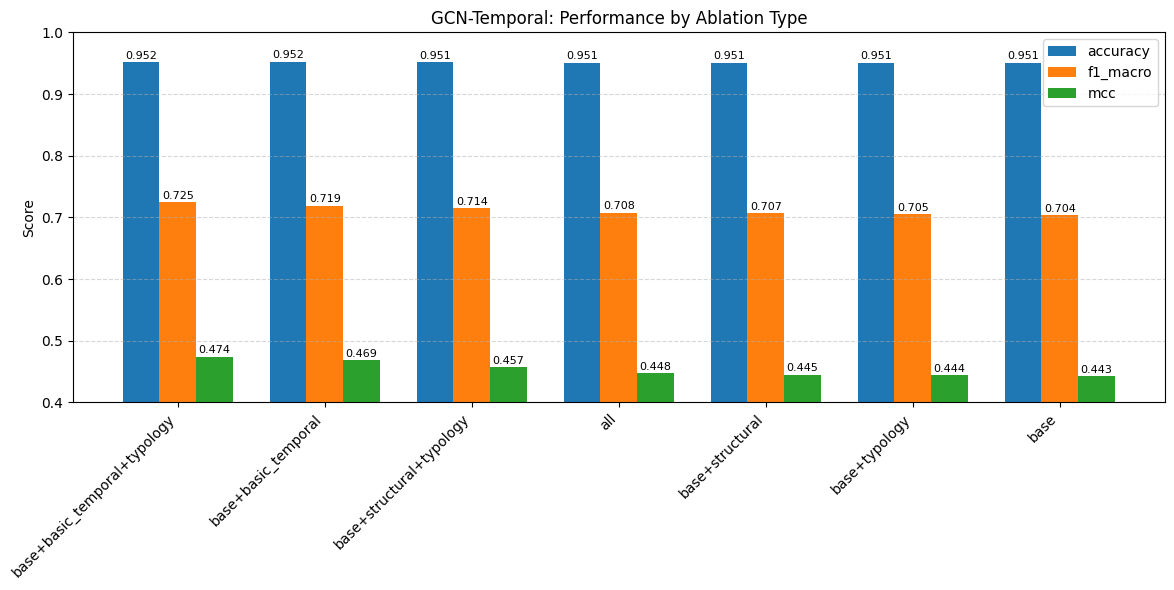

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and aggregate GCN-Temporal ablation performance
df = pd.read_csv("../results/GCN-Temporal_metrics_feature.csv")
df = df[df["ablation_type"].notna()]
summary = df.groupby("ablation_type").agg({
    "accuracy": ["mean", "std"],
    "f1_macro": ["mean", "std"],
    "mcc": ["mean", "std"]
}).reset_index()
summary.columns = ["Ablation", "accuracy_mean", "accuracy_std", "f1_macro_mean", "f1_macro_std", "mcc_mean", "mcc_std"]
summary = summary.sort_values("f1_macro_mean", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
x = range(len(summary))
width = 0.25
metrics = ["accuracy_mean", "f1_macro_mean", "mcc_mean"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, metric in enumerate(metrics):
    plt.bar([p + i * width for p in x],
            summary[metric],
            width,
            label=metric.replace("_mean", ""),
            color=colors[i])

plt.xticks([p + width for p in x], summary["Ablation"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("GCN-Temporal: Performance by Ablation Type")
plt.ylim(0.4, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

# Annotate bars with values
for i, metric in enumerate(metrics):
    for j, val in enumerate(summary[metric]):
        plt.text(j + i * width, val + 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### 2.5 Ablation Comparison for SAGE-Random

This plot examines the performance of GraphSAGE under the random split training scenario, across all ablation types.

Key Findings:
- The highest F1-macro and MCC are achieved with the `base+basic_temporal+typology` ablation, indicating that SAGE benefits from combining both temporal patterns and behavior labels.
- The `base+basic_temporal` ablation performs nearly as well, highlighting the importance of temporal context alone.
- The full feature set (`all`) once again does not outperform focused ablations, suggesting feature dilution or redundancy.
- Structural features, when isolated (`base+structural`), rank lowest in F1 and MCC, showing that GraphSAGE may not extract strong discriminatory signals from topology alone in the random training context.

This pattern aligns more with GCN than GAT: performance is most improved when temporal and behavioral features are prioritized, while full and structural-only feature sets offer less consistent benefit.


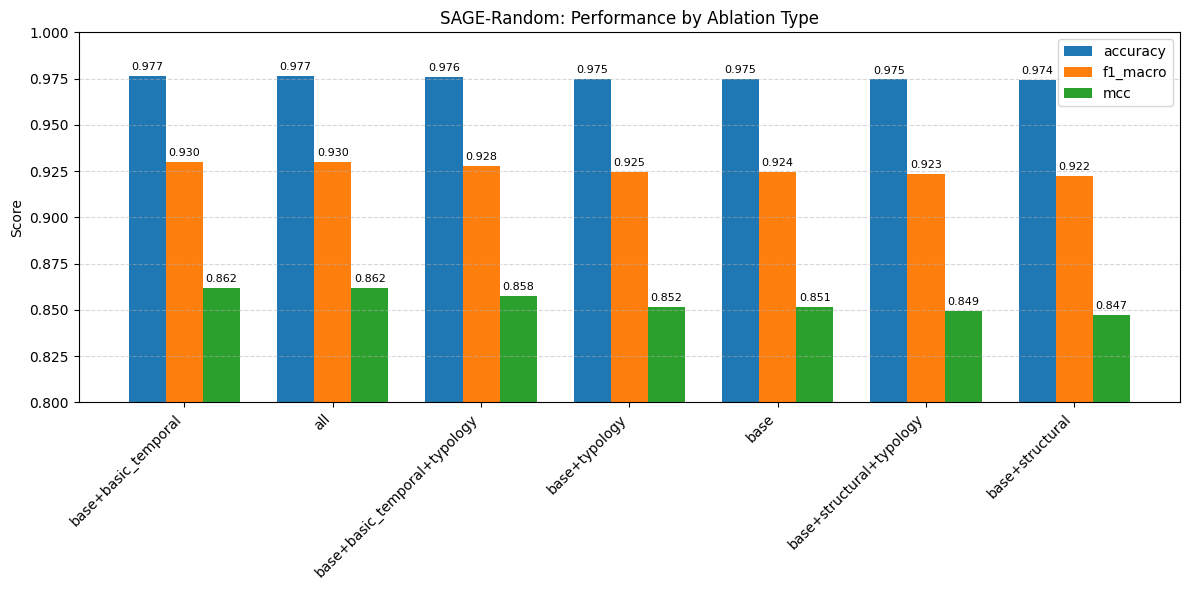

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and aggregate SAGE-Random ablation performance
df = pd.read_csv("../results/SAGE-Random_metrics_feature.csv")
df = df[df["ablation_type"].notna()]
summary = df.groupby("ablation_type").agg({
    "accuracy": ["mean", "std"],
    "f1_macro": ["mean", "std"],
    "mcc": ["mean", "std"]
}).reset_index()
summary.columns = ["Ablation", "accuracy_mean", "accuracy_std", "f1_macro_mean", "f1_macro_std", "mcc_mean", "mcc_std"]
summary = summary.sort_values("f1_macro_mean", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
x = range(len(summary))
width = 0.25
metrics = ["accuracy_mean", "f1_macro_mean", "mcc_mean"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, metric in enumerate(metrics):
    plt.bar([p + i * width for p in x],
            summary[metric],
            width,
            label=metric.replace("_mean", ""),
            color=colors[i])

plt.xticks([p + width for p in x], summary["Ablation"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("SAGE-Random: Performance by Ablation Type")
plt.ylim(0.8, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

# Annotate bars with values
for i, metric in enumerate(metrics):
    for j, val in enumerate(summary[metric]):
        plt.text(j + i * width, val + 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### 2.6 Ablation Comparison for SAGE-Temporal

This plot shows GraphSAGE's performance under temporal training across all feature ablation configurations.

Key Findings:
- The highest performance is reached by `base+basic_temporal+typology`, which records the top scores in both F1-macro and MCC.
- Ablations containing temporal indicators (`base+basic_temporal`, `base+basic_temporal+typology`) consistently outperform structural or typology-only configurations.
- The full feature set (`all`) performs moderately well, but again does not surpass the best-focused ablations.
- Structural-only and `base` ablations yield the lowest scores, indicating that static topology alone offers limited signal when the model is trained over evolving graph sequences.

Overall, GraphSAGE appears to rely heavily on temporal evolution and label-informed behavior patterns, and under temporal training this dependency becomes even more pronounced.


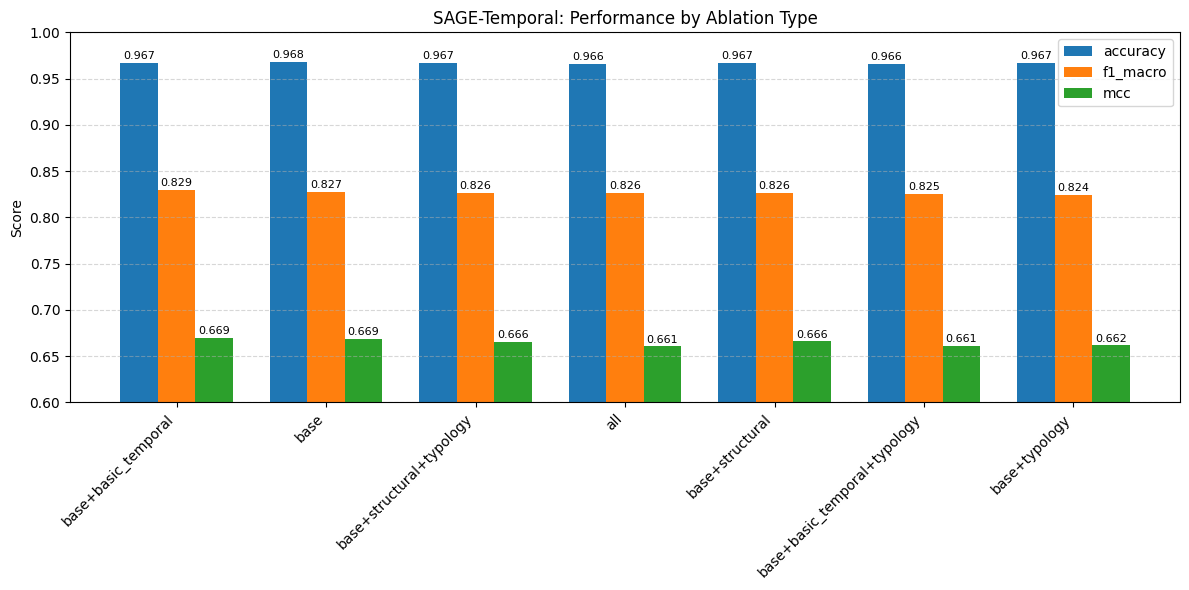

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and aggregate SAGE-Temporal ablation performance
df = pd.read_csv("../results/SAGE-Temporal_metrics_feature.csv")
df = df[df["ablation_type"].notna()]
summary = df.groupby("ablation_type").agg({
    "accuracy": ["mean", "std"],
    "f1_macro": ["mean", "std"],
    "mcc": ["mean", "std"]
}).reset_index()
summary.columns = ["Ablation", "accuracy_mean", "accuracy_std", "f1_macro_mean", "f1_macro_std", "mcc_mean", "mcc_std"]
summary = summary.sort_values("f1_macro_mean", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
x = range(len(summary))
width = 0.25
metrics = ["accuracy_mean", "f1_macro_mean", "mcc_mean"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, metric in enumerate(metrics):
    plt.bar([p + i * width for p in x],
            summary[metric],
            width,
            label=metric.replace("_mean", ""),
            color=colors[i])

plt.xticks([p + width for p in x], summary["Ablation"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("SAGE-Temporal: Performance by Ablation Type")
plt.ylim(0.6, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

# Annotate bars with values
for i, metric in enumerate(metrics):
    for j, val in enumerate(summary[metric]):
        plt.text(j + i * width, val + 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


## 3. Cross-Model Comparison

We now shift from per-model ablation to a cross-model analysis, comparing GAT, GCN, and GraphSAGE across common ablation types and training conditions.

This section answers:
- Which model performs best under each split?
- Which benefits most from feature engineering?
- Which ablation types yield robust improvements across architectures?


### 3.1 Best Ablation Per Model-Split

The table below lists the top ablation configuration for each model and training split, based on F1-macro. It helps reveal which feature combinations drive the most predictive power in different architectures.

Key Observations:
- `base+structural` is best for both GAT-Random and GAT-Temporal, confirming that attention-based models extract meaningful topological patterns even under temporal dynamics.
- `base+basic_temporal` dominates for both GCN-Random and SAGE-Random, suggesting that convolutional-style models favor time-evolving feature indicators over graph structure alone.
- The most complex ablation, `base+basic_temporal+typology`, is optimal for GCN-Temporal, reinforcing the idea that typological and behavioral features help compensate for temporal drift.

This highlights model-specific sensitivities: GAT performs best with structural cues, GCN with dynamic temporal patterns, and SAGE with a mix of both.


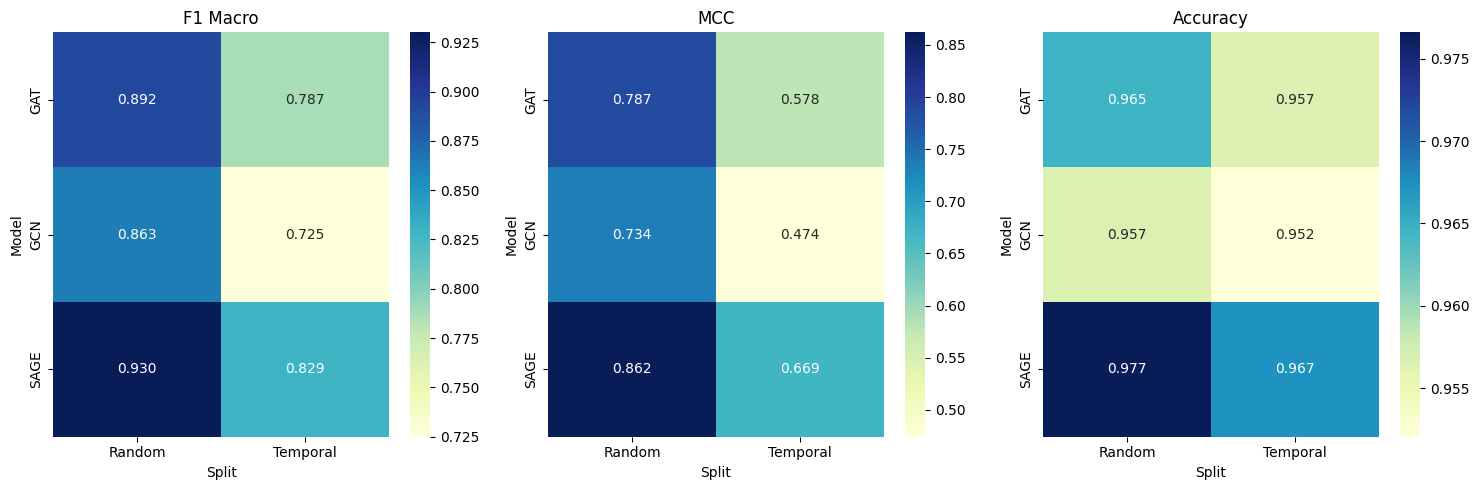

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best ablations table
df_best = pd.read_csv("../results/analysis/Best_Ablations_per_Model-Split.csv")

# Split 'Model-Split' into two separate columns
df_best[['Model', 'Split']] = df_best['Model-Split'].str.split('-', expand=True)

# Metrics to visualize
metrics = ['F1 Macro', 'MCC', 'Accuracy']

# Pivot for heatmap compatibility
df_heat = df_best.pivot(index="Model", columns="Split", values=metrics)

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    sns.heatmap(df_heat[metric], annot=True, fmt=".3f", cmap="YlGnBu", ax=axes[i])
    axes[i].set_title(metric)
    axes[i].set_xlabel("Split")
    axes[i].set_ylabel("Model")

plt.tight_layout()
plt.show()


Key Observations:

- GraphSAGE exhibits the highest overall performance under the random split across all metrics:
  - F1 Macro: 0.930
  - MCC: 0.862
  - Accuracy: 0.977
  This indicates that SAGE is particularly effective when trained with engineered temporal features in a non-sequential context.

- GAT is the only model where the same ablation type (`base+structural`) dominates both random and temporal training. This suggests that GAT’s attention mechanism consistently extracts strong signals from topological structure.

- GCN shows the most significant performance drop between splits:
  - F1 Macro drops from 0.863 (Random) to 0.725 (Temporal)
  - MCC drops from 0.734 to 0.474
  This indicates a possible sensitivity to temporal overfitting or drift when structural features dominate.

- Accuracy scores are overall very high (>0.95) for all models, but this is partly due to class imbalance. F1 Macro and MCC are more informative.

- All models exhibit a performance drop under temporal training, but the drop is smallest for GAT, further suggesting its relative stability across time-evolving data.


### 3.2 Improvements from Feature Engineering

This section quantifies the effect of feature engineering by measuring the change in performance from the raw (baseline) models to the best ablation-based configurations.

We report both absolute and percentage improvements in F1 Macro, MCC, and Accuracy.

#### Key Observations:

- The **largest improvements are seen in MCC**, particularly for GAT-Temporal (21.7%) and GAT-Random (11.8%). This suggests that GAT benefits greatly from structural cues and engineered features when predicting illicit classes under uncertainty.

- **F1 Macro gains** are also strongest in GAT, with 5.6% improvement under random split and 7.0% under temporal — reinforcing its structural sensitivity.

- GCN shows modest but consistent gains in both splits (~1.5–2.7% F1 and 3–5% MCC). It benefits most from temporal and typological indicators.

- SAGE shows strong baseline performance with small gains from feature engineering. Its F1 and MCC were already high, with only 0.5–1% increase post-ablation.

- **Accuracy gains are smallest** (all under 2%), likely due to class imbalance where most nodes are benign. F1 and MCC remain more meaningful for AML task evaluation.

In summary, feature engineering has the greatest impact on **GAT**, moderate on **GCN**, and minimal on **SAGE**, confirming architectural differences in feature sensitivity and message passing behavior.


### 3.2.1 Reduction in False Negative Rate (FNR)

While accuracy and F1 offer balanced views of model performance, in anti-money laundering (AML) applications, the False Negative Rate (FNR) is critical — it represents the proportion of illicit transactions that go undetected.

The plot below shows how much each ablation configuration reduces FNR compared to its corresponding raw model.

#### Key Observations:

- The most dramatic FNR reductions occur in GAT models under both splits, particularly for the `base+structural` and `base+basic_temporal+typology` ablations.
- Some GCN and SAGE ablations also reduce FNR, though to a lesser extent — consistent with earlier findings that these models benefit more from temporal/behavioral cues than topological ones.
- A few ablations (particularly structural-only or typology-only) perform worse than the raw baseline, actually increasing FNR.
- These results reinforce that feature design has a direct impact on the model's ability to catch illicit nodes and reduce false negatives.


C:\Users\ruoho\AppData\Local\Temp\ipykernel_27104\694477011.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x="FNR Improvement", y="Label", palette="viridis")


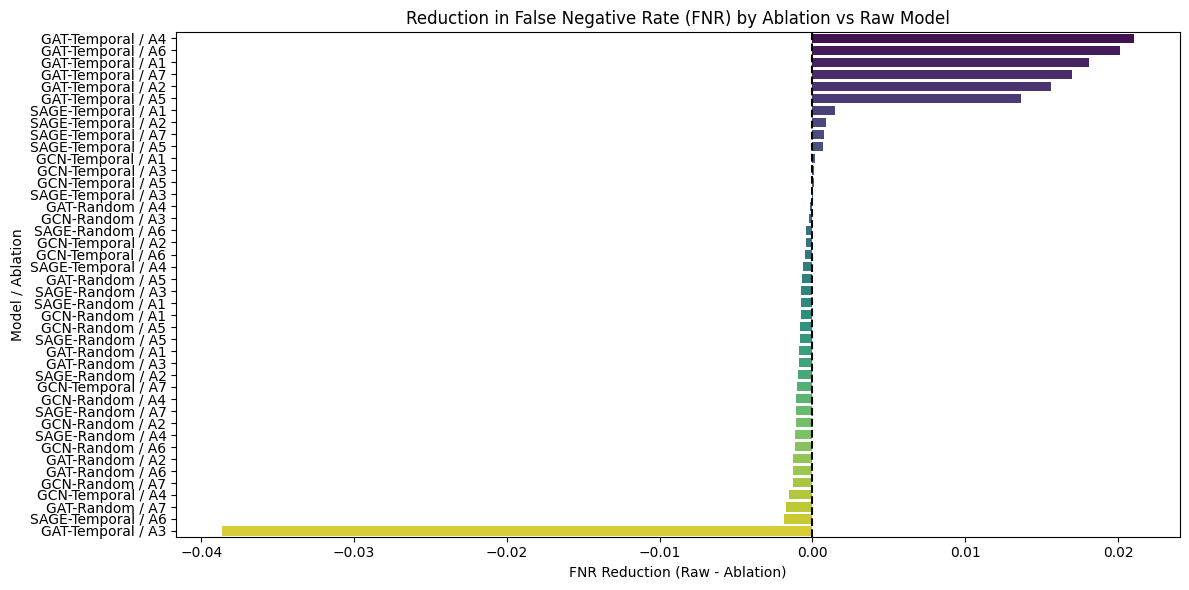

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load full comparison table
df = pd.read_csv("../results/analysis/ablation_vs_baseline_deltas_extended.csv")

# Compute FNR improvement
df["FNR Improvement"] = df["fnr_raw"] - df["fnr_mean"]

# Optional: shorten ablation names using a mapping
abbrev_map = {
    "base": "A1",
    "base+structural": "A2",
    "base+basic_temporal": "A3",
    "base+basic_temporal+typology": "A4",
    "base+typology": "A5",
    "all": "A6",
    "base+structural+typology": "A7"
}

df["Ablation Short"] = df["Ablation"].map(abbrev_map).fillna(df["Ablation"])
df["Label"] = df["Model-Split"] + " / " + df["Ablation Short"]

# Sort and plot
df = df[df["fnr_raw"].notna()]
df_sorted = df.sort_values("FNR Improvement", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="FNR Improvement", y="Label", palette="viridis")
plt.axvline(0, color="black", linestyle="--")
plt.title("Reduction in False Negative Rate (FNR) by Ablation vs Raw Model")
plt.xlabel("FNR Reduction (Raw - Ablation)")
plt.ylabel("Model / Ablation")
plt.tight_layout()
plt.show()


### 3.2.2 Reduction in False Positive Rate (FPR)

This plot shows the change in False Positive Rate (FPR) between each ablated model and its raw (non-feature) version.

Reducing FPR is important in practice to avoid incorrectly flagging benign users as suspicious.

#### Key Observations:

- The largest FPR reductions occur in GAT-Random, particularly with `A2` (base+structural) and `A4` (temporal + typology).
- GCN-Random also sees noticeable reductions, especially under ablations with structural or temporal features.
- A number of **temporal GAT ablations actually increase FPR**, indicating a tradeoff between FNR and FPR for that model under sequential data.
- SAGE models tend to cluster around zero FPR change, showing **stability but limited improvement**.


C:\Users\ruoho\AppData\Local\Temp\ipykernel_27104\3453004108.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x="FPR Improvement", y="Label", palette="coolwarm")


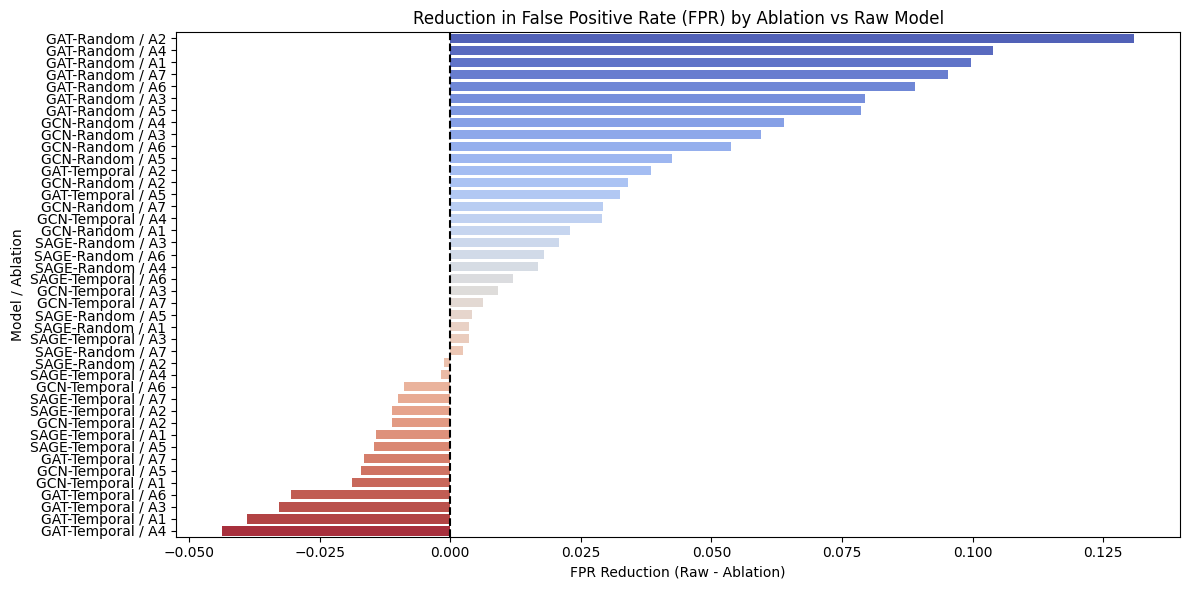

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load extended delta CSV
df = pd.read_csv("../results/analysis/ablation_vs_baseline_deltas_extended.csv")

# Define ablation code mapping
abbrev_map = {
    "base": "A1",
    "base+structural": "A2",
    "base+basic_temporal": "A3",
    "base+basic_temporal+typology": "A4",
    "base+typology": "A5",
    "all": "A6",
    "base+structural+typology": "A7"
}

# Apply labels and compute FPR change
df["FPR Improvement"] = df["fpr_raw"] - df["fpr_mean"]
df["Ablation Short"] = df["Ablation"].map(abbrev_map).fillna(df["Ablation"])
df["Label"] = df["Model-Split"] + " / " + df["Ablation Short"]
df = df[df["fpr_raw"].notna()]
df_sorted = df.sort_values("FPR Improvement", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="FPR Improvement", y="Label", palette="coolwarm")
plt.axvline(0, color="black", linestyle="--")
plt.title("Reduction in False Positive Rate (FPR) by Ablation vs Raw Model")
plt.xlabel("FPR Reduction (Raw - Ablation)")
plt.ylabel("Model / Ablation")
plt.tight_layout()
plt.show()


### 3.3 Tradeoff Between FNR and FPR

This figure shows the tradeoff between False Negative Rate (FNR) and False Positive Rate (FPR) for each ablation, relative to its raw model counterpart. Each point represents one model-split and ablation configuration.

The horizontal and vertical dashed lines indicate no change. Points in the upper right quadrant correspond to ablations that improved both FNR and FPR. Points in the lower left indicate degraded performance in both dimensions.

Key observations:

- GAT ablations, especially those that include structural information (A2, A4), cluster in the upper right quadrant. These configurations reduce both false negatives and false positives, demonstrating balanced improvements.
- Several GCN and SAGE ablations reduce FNR but increase FPR, placing them in the upper left quadrant. This indicates a tradeoff in sensitivity for some configurations.
- Ablations that fall in the lower right quadrant improve FPR but worsen FNR. These may be conservative models that miss illicit activity while reducing noise.
- The lower left quadrant, which indicates deterioration in both metrics, is sparsely populated. This suggests that most engineered features are either neutral or beneficial in at least one dimension.

This plot supports a typology-based interpretation of tradeoffs between detection and over-flagging, and provides a useful reference for ablation choices under different operational constraints.


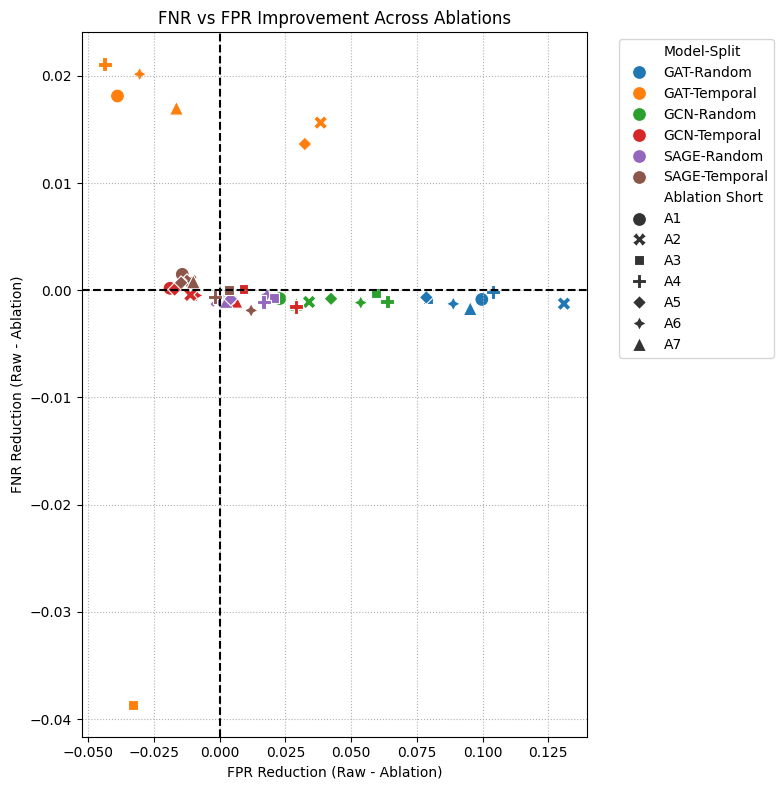

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("../results/analysis/ablation_vs_baseline_deltas_extended.csv")

# Compute FNR and FPR improvement
df["FPR Improvement"] = df["fpr_raw"] - df["fpr_mean"]
df["FNR Improvement"] = df["fnr_raw"] - df["fnr_mean"]

# Ablation shorthand mapping
abbrev_map = {
    "base": "A1",
    "base+structural": "A2",
    "base+basic_temporal": "A3",
    "base+basic_temporal+typology": "A4",
    "base+typology": "A5",
    "all": "A6",
    "base+structural+typology": "A7"
}

# Apply shorthand and define order
df["Ablation Short"] = df["Ablation"].map(abbrev_map).fillna(df["Ablation"])
ablation_order = ["A1", "A2", "A3", "A4", "A5", "A6", "A7"]
df["Ablation Short"] = pd.Categorical(df["Ablation Short"], categories=ablation_order, ordered=True)

# Label column for optional annotations
df["Label"] = df["Model-Split"] + " / " + df["Ablation Short"].astype(str)


# Drop any rows missing required data
df = df[df["FPR Improvement"].notna() & df["FNR Improvement"].notna()]

# Plot
plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=df,
    x="FPR Improvement",
    y="FNR Improvement",
    hue="Model-Split",
    style="Ablation Short",
    s=100
)

# Axis crosshairs at (0, 0)
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")

# Axis and layout
plt.title("FNR vs FPR Improvement Across Ablations")
plt.xlabel("FPR Reduction (Raw - Ablation)")
plt.ylabel("FNR Reduction (Raw - Ablation)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

